<a href="https://colab.research.google.com/github/emilymaccarthy/Music-Genre-Clasiffier/blob/main/TP3_TD6_COMPARTIDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**


In [ ]:
! pip install torchaudio
! pip install  pydub
!pip install wandb -qU
!export WANDB_API_KEY="a95c9a55fb9514b8525cfc91b011aeca88892820"


In [ ]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import wandb

import gc
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F
import wandb


API_KEY_GUIDO = "2342ab8676069737005119d650b0dd2cb154e898"

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True


# TP3: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




In [ ]:
project_name ='Music_genre_classification'

### 2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [ ]:
import os
#data_dir='/content/genres_5sec-20241026T141804Z-001.zip'

data_dir = '/content/drive/MyDrive/TD6/genres_5sec'

list_files=os.listdir(data_dir)
classes=[]
class_file_counts = {}
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
    num_files = len([f for f in os.listdir(name) if os.path.isfile(os.path.join(name, f))])
    class_file_counts[file] = num_files

# Display the number of files in each class
for class_name, count in class_file_counts.items():
    print(f"Class: {class_name}, Number of files: {count}")
classes

Class: jazz, Number of files: 99
Class: metal, Number of files: 99
Class: rock, Number of files: 99
Class: country, Number of files: 99
Class: disco, Number of files: 99
Class: pop, Number of files: 99
Class: reggae, Number of files: 99
Class: classical, Number of files: 99
Class: blues, Number of files: 99
Class: hiphop, Number of files: 99


['jazz',
 'metal',
 'rock',
 'country',
 'disco',
 'pop',
 'reggae',
 'classical',
 'blues',
 'hiphop']

In [ ]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]

        #img = self.transform(open_image(fpath))
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]

        return audio, class_idx
dataset = MusicDataset(data_dir)

### 3. Visualización de los archivos

In [ ]:
waveform,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 9 


shape of spectogram torch.Size([1, 201, 552])


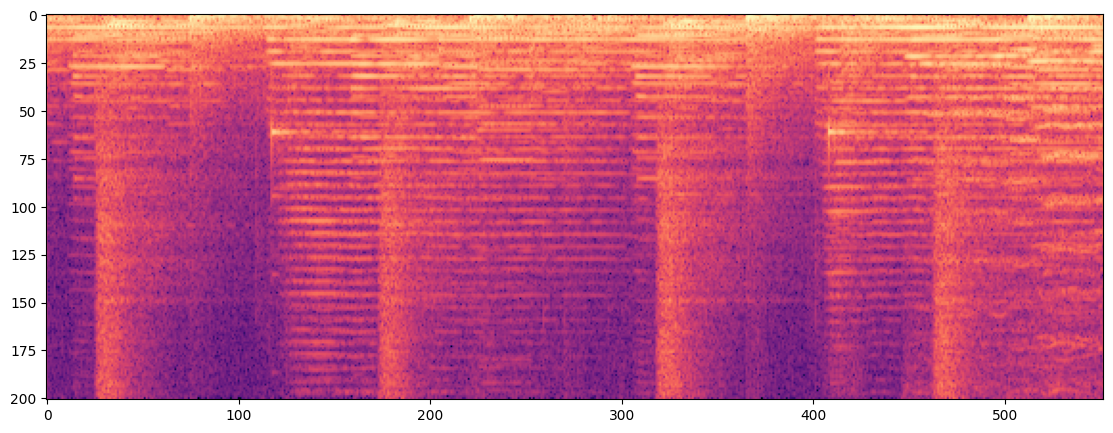

In [ ]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')


Waveform: tensor([[ 0.0024,  0.0055,  0.0087,  ..., -0.0035, -0.0028,  0.0053]])



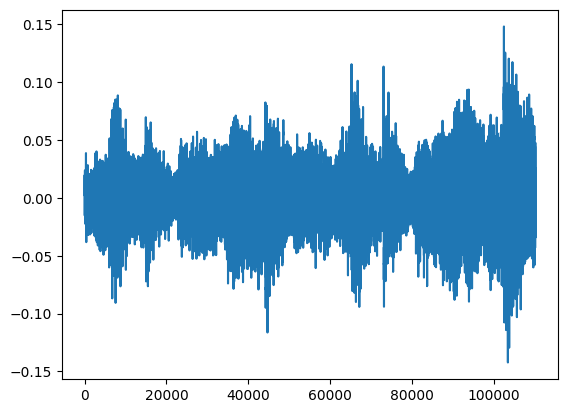

In [ ]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [ ]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [ ]:
specgram.size()

torch.Size([1, 201, 552])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20

# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
#test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=2, pin_memory=True)

### 4. Clasificación

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Usar GPU
    print("Usando GPU:", torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")  # Usar CPU como respaldo
    print("Usando CPU")

Usando CPU


In [ ]:
hidden_dimensions = 64

class MLP(nn.Module):
    def __init__(self, n_input, hidden_dim=hidden_dimensions, n_output=10):
        super(MLP, self).__init__()
        # Define layers dynamically
        self.fc1 = nn.Linear(n_input, hidden_dim)  # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, n_output)  # Output layer


    def forward(self, x):
        x = F.relu(self.fc1(x))  # First hidden layer with ReLU
        x = F.relu(self.fc2(x))  # Second hidden layer with ReLU
        x = self.fc3(x)          # Output layer, no activation as it's used for logits
        return F.log_softmax(x, dim=1)


model = MLP(n_input=110250, n_output=len(classes))
model.to(device)

n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 7060874


In [ ]:
class CNN_1D(nn.Module):
    def __init__(self, n_input, hidden_dim=1, n_output=10):
        super(CNN_1D, self).__init__()
        self.architecture = 'CNN_1D'
        self.spectrogram = tt.Spectrogram().to(device)

        # Definir las capas convolucionales
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=20, kernel_size=100, stride=1, padding=0)
        self.conv2 = nn.Conv1d(in_channels=20, out_channels=40, kernel_size=20, stride=5, padding=0)
        self.conv3 = nn.Conv1d(in_channels=40, out_channels=40, kernel_size=20, stride=5, padding=0)

        # Definir la capa de max pooling
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Flatt
        self.flatten = nn.Flatten()

        # Definir las capas completamente conectadas (fully connected)
        self.fc1 = nn.Linear(44000, 256)  # Cambia el tamaño si las imágenes de entrada son diferentes
        self.fc2 = nn.Linear(256, n_output)

        # Capa de Dropout para prevenir sobreajuste
        self.dropout = nn.Dropout(0.5)



        self.a = 0

    def forward(self, x):
        # Pasar por las capas convolucionales con ReLU y max pooling
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.flatten(x)

        if self.a == 0:
            print(x.shape)
            self.a = 1

        # Pasar por las capas totalmente conectadas
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN_1D(n_input=110250, n_output=len(classes))
model.to(device)

n = count_parameters(model)
print("Number of parameters: %s" % n)


Number of parameters: 11316926


In [ ]:
class CNN_2D(nn.Module):
    def __init__(self, n_input, hidden_dim=1, n_output=10):
        super(CNN_2D, self).__init__()
        self.architecture = 'CNN_2D'

        self.spectrogram = tt.Spectrogram().to(device)

        # # Definir las capas convolucionales
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(20,5), stride=1, padding=1)
        # self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1)

        # Definir las capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(50,20), stride=10, padding=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=10, stride=5, padding=1)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)

        # Definir la capa de max pooling
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Definir las capas completamente conectadas (fully connected)
        self.fc1 = nn.Linear(30, 100)  # Cambia el tamaño si las imágenes de entrada son diferentes
        self.fc2 = nn.Linear(100, n_output)

        # Capa de Dropout para prevenir sobreajuste
        self.dropout = nn.Dropout(0.5)

        # Flatt
        self.flatten = nn.Flatten()

        self.a = 0

    def forward(self, x):
        # Pasar por las capas convolucionales con ReLU y max pooling
        x = self.spectrogram(x)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.flatten(x)

        if self.a == 0:
            print(x.shape)
            self.a = 1

        # Pasar por las capas totalmente conectadas
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN_2D(n_input=110250, n_output=len(classes))
model.to(device)

n = count_parameters(model)
print("Number of parameters: %s" % n)


Number of parameters: 19040


In [ ]:

learning_rate = 0.005
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
valid_losses = []
best_acc = 0
num_epochs = 30

wandb.init(
    project="tp3-td6",
    config={
        "learning_rate": learning_rate,
        "architecture": model.architecture,
        "dataset": "genres_5sec",
        "epochs": num_epochs,
        "batch_size": batch_size,
        "hidden_dim": hidden_dimensions,
        "optimizer": "Adam",
        "loss_function": "CrossEntropyLoss",
        "Model": model.__str__(),
        "n_parametros":n
    }
)

# TRAIN
for epoch in range(num_epochs):
    model.train()
    train_loss_epoch = []
    for wav, genre_index in train_dl:
        optimizer.zero_grad()
        wav, genre_index = wav.to(device), torch.as_tensor(genre_index).to(device)

        output = model.forward(wav)
        loss = loss_function(output.squeeze(), genre_index)
        loss.backward()
        optimizer.step()
        train_loss_epoch.append(loss.item())

    # Validación
    model.eval()
    val_loss_epoch = []
    y_true, y_pred = [], []
    correct = 0
    with torch.no_grad():
        for wav, genre_index in valid_dl:
            wav, genre_index = wav.to(device), genre_index.to(device)
            out = model(wav)

            loss = loss_function(out.squeeze(), genre_index)
            val_loss_epoch.append(loss.item())

            pred = out.argmax(dim=-1).flatten()
            correct += pred.eq(genre_index).sum().item()
            y_true.extend(genre_index.tolist())
            y_pred.extend(pred.tolist())

    # Log results
    train_loss = np.mean(train_loss_epoch)
    valid_loss = np.mean(val_loss_epoch)
    accuracy = correct / len(valid_dl.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    wandb.log({
        'train_loss': train_loss,
        'epoch': epoch + 1,
        'accuracy': accuracy,
        'valid_loss': valid_loss,
        'Acccuracy': accuracy,
    })

    print(f'Epoch: [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Save best model
    if valid_loss < best_acc:
        best_acc = valid_loss
        print(f'Saving the best model at epoch {epoch + 1}!')
        torch.save(model.state_dict(), 'best_model.ckpt')

    # Free memory after each epoch
    torch.cuda.empty_cache()
    gc.collect()

wandb.finish()






torch.Size([20, 44000])
Epoch: [1/30], Train loss: 2.5261, Valid loss: 2.3074, Accuracy: 0.0800
Epoch: [2/30], Train loss: 2.2733, Valid loss: 2.3251, Accuracy: 0.1200
Epoch: [3/30], Train loss: 2.3057, Valid loss: 2.3254, Accuracy: 0.0600


KeyboardInterrupt: 

# 4,5. SKLearn Guido

In [ ]:
from sklearn.model_selection import ParameterGrid
import numpy as np
import torch
import torch.nn as nn

def run_grid_search(model_class, train_dl, valid_dl, param_grid, num_epochs, device):
    best_params = None
    best_accuracy = 0
    best_model_state = None

    # Generar combinaciones de hiperparámetros a probar
    grid = ParameterGrid(param_grid)

    for params in grid:
        print(f"Evaluating parameters: {params}")

        # Crear una nueva instancia del modelo para cada combinación de hiperparámetros
        activation_fn = params.get("activation_fn", nn.ReLU)()
        model = model_class(activation_fn=activation_fn).to(device)

        # Configurar el optimizador
        optimizer_name = params.get("optimizer", "Adam")
        learning_rate = params.get("learning_rate", 0.005)

        if optimizer_name == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        elif optimizer_name == "RMSprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
        else:
            raise ValueError(f"Optimizer {optimizer_name} not supported")

        # Configurar la función de pérdida
        loss_function = params.get("loss_function", nn.CrossEntropyLoss)()

        # Entrenamiento y validación por cada conjunto de parámetros
        for epoch in range(num_epochs):
            model.train()
            train_loss_epoch = []
            for wav, genre_index in train_dl:
                optimizer.zero_grad()
                wav, genre_index = wav.to(device), torch.as_tensor(genre_index).to(device)

                output = model(wav)
                loss = loss_function(output.squeeze(), genre_index)
                loss.backward()
                optimizer.step()
                train_loss_epoch.append(loss.item())

            # Validación
            model.eval()
            correct = 0
            with torch.no_grad():
                for wav, genre_index in valid_dl:
                    wav, genre_index = wav.to(device), genre_index.to(device)
                    out = model(wav)
                    pred = out.argmax(dim=-1).flatten()
                    correct += pred.eq(genre_index).sum().item()

            accuracy = correct / len(valid_dl.dataset)

            # Guardar el mejor modelo
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = params
                best_model_state = model.state_dict()

        print(f"Finished evaluation of {params}, Accuracy: {accuracy:.4f}")

    print("Best Parameters:", best_params)
    print("Best Accuracy:", best_accuracy)

    # Cargar el mejor estado del modelo
    model.load_state_dict(best_model_state)

    return best_params, best_accuracy, model



In [ ]:
# param_grid = {
#     'learning_rate': [0.001, 0.005, 0.01],
#     'batch_size': [32, 64],
#     'hidden_dim': [64, 128],
#     'optimizer': ['Adam', 'SGD', 'RMSprop'],
#     'activation_fn': [nn.ReLU, nn.Tanh, nn.LeakyReLU],
#     'loss_function': [nn.CrossEntropyLoss, nn.NLLLoss]
# }
learning_rate = 0.005
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
valid_losses = []
best_acc = 0
num_epochs = 30

param_grid = {
    'learning_rate': learning_rate,
    'batch_size': [32, 64],
    'hidden_dim': 64,
    'optimizer': 'Adam',
    'activation_fn': [nn.ReLU, nn.Tanh, nn.LeakyReLU],
    'loss_function': nn.CrossEntropyLoss
}

best_params, best_accuracy, best_model = run_grid_search(MyModelClass, train_dl, valid_dl, param_grid, num_epochs=10, device=device)




### 5. Evaluación



In [ ]:
test_dl = DataLoader(test_ds,1,shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
# Load the best model
S = torch.load('best_model.ckpt')
model.load_state_dict(S)
print('loaded!')

# Run evaluation
model.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for wav, genre_index in test_dl:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy =correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Test loss: %.4f, Test accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))


In [ ]:
waveform,label= test_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

In [ ]:
import IPython
IPython.display.Audio(waveform, rate=22050)

In [ ]:
wav= torch.unsqueeze(waveform, dim=0)
model.to(device)
wav =wav.to(device)
out = model(wav)
pred= out.argmax(dim=-1).flatten()
classes[pred], classes[label]